In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import seaborn as sns, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding, LSTM, Dropout
from keras.optimizers import Adam
nltk.download("stopwords")
nltk.download("punkt")
from nltk.corpus import stopwords
tf.test.gpu_device_name()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


'/device:GPU:0'

In [3]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv')

In [4]:
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [5]:
data.shape

(50000, 2)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


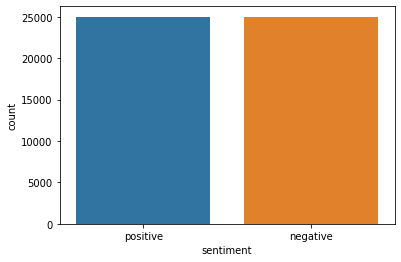

negative    25000
positive    25000
Name: sentiment, dtype: int64


In [8]:
sns.countplot(data['sentiment'])
plt.show()
print(data.sentiment.value_counts())

In [9]:
data.sentiment=[1 if sentiment=='positive' else 0 for sentiment in data.sentiment]

In [10]:
print(data.sentiment.value_counts())

1    25000
0    25000
Name: sentiment, dtype: int64


In [11]:
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


In [12]:
WPT= nltk.WordPunctTokenizer()
stop_words_list=nltk.corpus.stopwords.words('english')

In [13]:
print(stop_words_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [14]:
data['review'] = data['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
data['review'] = data['review'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))

data['review'] = data['review'].apply(lambda x: x.lower())

data['review'] = data['review'].apply(lambda x: x.strip())

In [15]:
data.head(10)

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the ...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1
5,probably my all time favorite movie a story of...,1
6,i sure would like to see a resurrection of a u...,1
7,this show was an amazing fresh innovative id...,0
8,encouraged by the positive comments about this...,0
9,if you like original gut wrenching laughter yo...,1


In [16]:
# def token(values):
#    words = nltk.tokenize.word_tokenize(values)
#    filtered_words = [word for word in words if word not in set(stopwords.words("english"))]
#    not_stopword_doc = " ".join(filtered_words)
#    return not_stopword_doc
# data['review'] = data['review'].apply(lambda x: token(x))

In [17]:
sentiment=data.sentiment.values
sentiment

array([1, 1, 1, ..., 0, 0, 0])

In [18]:
data=data['review']

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train , y_test = train_test_split(data,sentiment,test_size=0.2)

In [20]:
print('Train set size:',x_train.shape)
print('Test set size:', x_test.shape)


Train set size: (40000,)
Test set size: (10000,)


In [21]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
tokenizer= Tokenizer(num_words=15000)
tokenizer.fit_on_texts(data)

In [22]:
print(tokenizer.word_index)

Output hidden; open in https://colab.research.google.com to view.

In [23]:
x_train_token= tokenizer.texts_to_sequences(x_train)
x_test_token= tokenizer.texts_to_sequences(x_test)

In [24]:
print(x_train_token)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [25]:
num_tokens=[len(num) for num in x_train_token+x_test_token]
num_tokens=np.array(num_tokens)

In [26]:
num_tokens

array([470, 267, 120, ..., 259, 142, 394])

In [27]:
max_tokens=np.mean(num_tokens)+2*np.std(num_tokens)
max_tokens=int(max_tokens)
max_tokens

567

In [28]:
np.sum(num_tokens<max_tokens)/len(num_tokens)

0.94524

In [29]:
x_train_pad = pad_sequences(x_train_token, maxlen=max_tokens)
x_test_pad = pad_sequences(x_test_token, maxlen=max_tokens)

In [30]:
x_train_pad.shape

(40000, 567)

In [31]:
idx=tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))
print(inverse_map)

Output hidden; open in https://colab.research.google.com to view.

In [32]:
def return_to_sentence(tokens):
  words= [inverse_map[token] for token in tokens if token!=0]
  text=' '.join(words)
  return text

In [33]:
print(return_to_sentence(x_train_pad[215]))

you know those movies that are so bad that you have to laugh half caste wasn t one of them which sounds good right but no it s not it s not a bad attempt at a horror movie that s fun to watch because it s lame or not well acted or has bad special effects or anything else like that no half caste is just plain boring they don t even make an attempt to be scary until the last minutes are so it s just kids running around in the african bush country and getting high off of elephant dung for the first of the movie and it s not even funny the last minutes though are hilarious i have no idea what happened but it was really fun to watch that cgi leopard rip out the throats of all of those white guys i couldn t tell apart anyway if you re in the mood for a bad horror movie don t rent this one because you ll go to sleep before they get to the fun stuff if you do accidentally rent this movie i d recommend fast forwarding to the end and skipping any scene that happens in daylight you won t miss any

In [34]:
print(x_train_pad[215])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [35]:
model=Sequential()

embedding_size=50

model.add(Embedding(input_dim=15000, output_dim=embedding_size,input_length=max_tokens,name='Embedding_Layer' ))

model.add(LSTM(units=16,return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=8, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=4))
model.add(Dropout(0.1))

model.add(Dense(1, activation='sigmoid'))

optimizer =Adam(lr=1e-3)

model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_Layer (Embedding)  (None, 567, 50)           750000    
_________________________________________________________________
lstm (LSTM)                  (None, 567, 16)           4288      
_________________________________________________________________
dropout (Dropout)            (None, 567, 16)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 567, 8)            800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 567, 8)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0

In [37]:
history=model.fit(x_train_pad,y_train,validation_split=0.3, epochs=5, batch_size=1000, shuffle=True, verbose=1)

Epoch 1/5
28/28 [==============================] - 71s 2s/step - loss: 0.6912 - accuracy: 0.5340 - val_loss: 0.6682 - val_accuracy: 0.6641
Epoch 2/5
28/28 [==============================] - 64s 2s/step - loss: 0.6239 - accuracy: 0.7197 - val_loss: 0.4830 - val_accuracy: 0.8112
Epoch 3/5
28/28 [==============================] - 64s 2s/step - loss: 0.4471 - accuracy: 0.8390 - val_loss: 0.4094 - val_accuracy: 0.8487
Epoch 4/5
28/28 [==============================] - 64s 2s/step - loss: 0.3504 - accuracy: 0.8947 - val_loss: 0.3657 - val_accuracy: 0.8654
Epoch 5/5
28/28 [==============================] - 64s 2s/step - loss: 0.2842 - accuracy: 0.9230 - val_loss: 0.3461 - val_accuracy: 0.8707


In [38]:
result= model.evaluate(x_test_pad, y_test)

313/313 [==============================] - 127s 405ms/step - loss: 0.3581 - accuracy: 0.8647


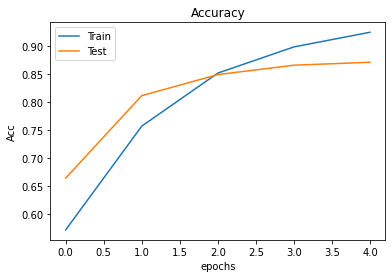

In [46]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

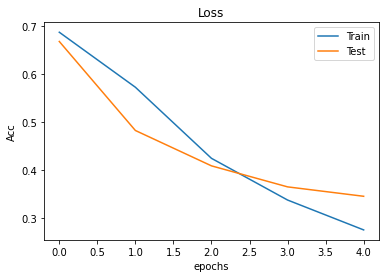

In [47]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()